In [1]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [3]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbar')

In [4]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '2000-01-01'
#start_of_epoch = '2016-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2017-12-31'

In [5]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red',
                     'nir',
                     #'swir1',
                     #'swir2'
                     ]

In [6]:
query = {
    'time': (start_of_epoch, end_of_epoch)}

In [7]:
#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -14.871098
lat_min = -14.930250
lon_max = 128.695821
lon_min = 128.619400
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)

In [8]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
loaded ls5_nbart_albers
making mask ls5_pq_albers
masked ls5_nbart_albers with ls5_pq_albers and filtered terrain
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


In [9]:
print(sensor1_nbart)

<xarray.Dataset>
Dimensions:  (time: 138, x: 340, y: 269)
Coordinates:
  * time     (time) datetime64[ns] 2003-07-04T01:05:59.500000 ...
  * y        (y) float64 -1.582e+06 -1.582e+06 -1.582e+06 -1.582e+06 ...
  * x        (x) float64 -3.671e+05 -3.671e+05 -3.671e+05 -3.67e+05 ...
Data variables:
    red      (time, y, x) float64 3.113e+03 3.072e+03 2.989e+03 3.113e+03 ...
    nir      (time, y, x) float64 3.738e+03 3.58e+03 3.632e+03 3.738e+03 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00,-367125.00|\n| 0.00,-25.00,-1582075.00|\n| 0.00, ...


In [49]:
all_sens = xr.concat([sensor1_nbart, sensor2_nbart, sensor3_nbart], 'time')
all_sens

<xarray.Dataset>
Dimensions:  (time: 575, x: 340, y: 269)
Coordinates:
  * y        (y) float64 -1.582e+06 -1.582e+06 -1.582e+06 -1.582e+06 ...
  * x        (x) float64 -3.671e+05 -3.671e+05 -3.671e+05 -3.67e+05 ...
  * time     (time) datetime64[ns] 2003-07-04T01:05:59.500000 ...
Data variables:
    red      (time, y, x) float64 3.113e+03 3.072e+03 2.989e+03 3.113e+03 ...
    nir      (time, y, x) float64 3.738e+03 3.58e+03 3.632e+03 3.738e+03 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00,-367125.00|\n| 0.00,-25.00,-1582075.00|\n| 0.00, ...

In [50]:
all_sens['ndvi'] = (all_sens['nir'] - all_sens['red']) / (all_sens['nir'] + all_sens['red'])

# Load bom_rainfall grids from the datacube (or from file)

In [12]:
#setup rain directory where we have put our pickle data
rainpath ='/g/data1/zk34/njs547/Rainfall_EK'

In [13]:
try:
        os.mkdir(rainpath)
except OSError as err:
        print("OS error: {0}".format(err))

OS error: [Errno 17] File exists: '/g/data1/zk34/njs547/Rainfall_EK'


In [14]:
# Edit query if need be

query['time'] = ('1978-01-01', '2017-11-01')

In [15]:
import pickle

try:
    #try to get the rain data from a pickle file saved earlier
    f = open(rainpath+'/DEA_Hack_rainfall_data'+'.pkl', 'rb')
    rain = pickle.load(f)
    Studysite_rain = rain['Studysite_rain']
    print('loaded rainfall grids from file:'+rainpath+'DEA_Hack_rainfall_data.pkl')
    f.close()
except:
    #Grab bom_rainfall_grids from the datacube
    print('loading bom rainfall grids from datacube')
    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save
    vars2pickle = {'Studysite_rain':Studysite_rain}
    f = open(rainpath+'/DEA_Hack_rainfall_data.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    print('saving rainfall data to file')
    #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loaded rainfall grids from file:/g/data1/zk34/njs547/Rainfall_EKDEA_Hack_rainfall_data.pkl


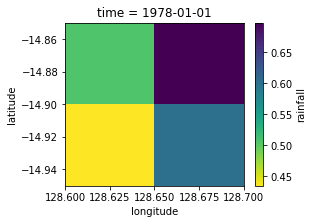

In [16]:
plt.figure(figsize=(4,3))
fig = Studysite_rain.rainfall.isel(time = [0]).plot()
#reverse the colourmap so high rainfall is blue
fig.set_cmap('viridis_r')
#print (Studysite_rain_masked)
plt.show()

In [17]:
#resample xarray Dataset Studysite_rain by year 'AS' 
month_sum = Studysite_rain.resample('MS', dim='time', how='sum', keep_attrs=True)

In [18]:
print(month_sum)

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 2, time: 432)
Coordinates:
  * latitude   (latitude) float64 -14.88 -14.93
  * longitude  (longitude) float64 128.6 128.7
  * time       (time) datetime64[ns] 1978-01-01 1978-02-01 1978-03-01 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 332.932 339.314 323.48 ...
Attributes:
    crs:      EPSG:4326


<xarray.DataArray 'time' (time: 432)>
array(['1978-01-01T00:00:00.000000000', '1978-02-01T00:00:00.000000000',
       '1978-03-01T00:00:00.000000000', ..., '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1978-01-01 1978-02-01 1978-03-01 ...


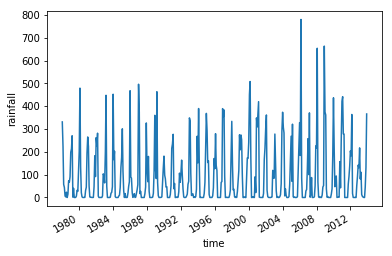

In [19]:
# PLot

month_sum.rainfall.mean(dim = ['longitude', 'latitude']).plot()
print(month_sum.time)
plt.show()

In [20]:
# This function calculates the residual mass rainfall curve

def calculate_residual_mass_curve(a):
    # find the number of time steps
    
    n = len(a.rainfall.time)/12
    
    # First calculate a cumulative rainfall xarray
    
    arr = a.rainfall.values
    
    cum_rf = np.cumsum(arr, axis = 0)
    
    cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    # Find the average of all months
    ave_months = a.rainfall.groupby('time.month').mean('time').values
    
    # Since we are starting with a water year we need to reorder the array so that July is first

    wy_month_ave = np.concatenate((ave_months[6:,:,:], ave_months[0:6,:,:]), axis = 0)

    print(np.shape(wy_month_ave))
    # Can certainly use tile here but will do a number of years rather than on n as defined here
    tiled_ave = np.tile(wy_month_ave, (round(n), 1, 1))
    
    if (n).is_integer() == False:
        month_remainder = int(round((n%1) * 12))

        tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        

    cum_ave = np.cumsum(tiled_ave, axis = 0)
    
    cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    mass_res_curve = cum_rf_xr - cum_ave_xr
    
    return mass_res_curve

(12, 2, 2)


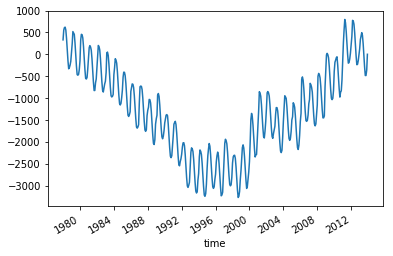

In [31]:
mass_res_curve = calculate_residual_mass_curve(month_sum)    

mass_res_curve.mean(dim = ('latitude', 'longitude')).plot()


plt.show()

In [60]:

# NOw grounp the mass residual curve by calendar year
yearly_mass_res = mass_res_curve.groupby('time.year').mean()

yearly_mass_res



<xarray.DataArray (year: 36)>
array([  1.629815e+02,  -1.884636e+00,  -6.617847e+01,  -2.859637e+02,
        -3.427621e+02,  -5.190877e+02,  -6.335342e+02,  -9.130081e+02,
        -1.163808e+03,  -1.212268e+03,  -1.502964e+03,  -1.447847e+03,
        -1.827931e+03,  -2.024330e+03,  -2.515034e+03,  -2.638842e+03,
        -2.721996e+03,  -2.576469e+03,  -2.729827e+03,  -2.476694e+03,
        -2.738409e+03,  -2.569614e+03,  -1.938537e+03,  -1.414312e+03,
        -1.366129e+03,  -1.714145e+03,  -1.471901e+03,  -1.636644e+03,
        -1.138653e+03,  -1.155125e+03,  -9.307551e+02,  -4.967875e+02,
        -4.724712e+02,   2.073561e+02,   2.434561e+02,   3.377458e+01])
Coordinates:
  * year     (year) int64 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 ...

In [61]:
# Set name for meging purposes

yearly_mass_res.name = 'Averaged mass residual'

In [62]:
yearly_mass_res

<xarray.DataArray 'Averaged mass residual' (year: 36)>
array([  1.629815e+02,  -1.884636e+00,  -6.617847e+01,  -2.859637e+02,
        -3.427621e+02,  -5.190877e+02,  -6.335342e+02,  -9.130081e+02,
        -1.163808e+03,  -1.212268e+03,  -1.502964e+03,  -1.447847e+03,
        -1.827931e+03,  -2.024330e+03,  -2.515034e+03,  -2.638842e+03,
        -2.721996e+03,  -2.576469e+03,  -2.729827e+03,  -2.476694e+03,
        -2.738409e+03,  -2.569614e+03,  -1.938537e+03,  -1.414312e+03,
        -1.366129e+03,  -1.714145e+03,  -1.471901e+03,  -1.636644e+03,
        -1.138653e+03,  -1.155125e+03,  -9.307551e+02,  -4.967875e+02,
        -4.724712e+02,   2.073561e+02,   2.434561e+02,   3.377458e+01])
Coordinates:
  * year     (year) int64 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 ...

In [63]:
# Now we get back to our nbar data and we calculate the 25th percentile NDVI for each year

def quantile(x):
    # Not doing quantile to save time
    return x.mean(dim = 'time')
    #return x.quantile(0.25, dim = 'time')


ndvi_p25 = all_sens.ndvi.groupby('time.year').apply(quantile)

ndvi_p25

<xarray.DataArray 'ndvi' (year: 18, y: 269, x: 340)>
array([[[ 0.018824,  0.027944, ...,  0.115622,  0.119571],
        [ 0.019247,  0.018754, ...,  0.110115,  0.115948],
        ..., 
        [ 0.417619,  0.409503, ...,  0.348513,  0.352102],
        [ 0.421705,  0.415121, ...,  0.347456,  0.367319]],

       [[ 0.171673,  0.1653  , ...,  0.109081,  0.110225],
        [ 0.174788,  0.17637 , ...,  0.107472,  0.110079],
        ..., 
        [ 0.422761,  0.41748 , ...,  0.4097  ,  0.413479],
        [ 0.424882,  0.418027, ...,  0.41185 ,  0.422782]],

       ..., 
       [[ 0.081644,  0.08441 , ...,  0.080739,  0.080501],
        [ 0.080872,  0.084371, ...,  0.082686,  0.08147 ],
        ..., 
        [ 0.540875,  0.52233 , ...,  0.493386,  0.492681],
        [ 0.5108  ,  0.503706, ...,  0.480399,  0.501133]],

       [[ 0.133343,  0.133597, ...,  0.116911,  0.118589],
        [ 0.133861,  0.135024, ...,  0.117679,  0.121439],
        ..., 
        [ 0.533707,  0.523599, ...,  0.416209,

In [64]:
# Merge the nbar data with the yearly average residual madd

merged_data = xr.merge([ndvi_p25, yearly_mass_res])
merged_data

<xarray.Dataset>
Dimensions:                 (x: 340, y: 269, year: 40)
Coordinates:
  * year                    (year) int64 1978 1979 1980 1981 1982 1983 1984 ...
  * y                       (y) float64 -1.582e+06 -1.582e+06 -1.582e+06 ...
  * x                       (x) float64 -3.671e+05 -3.671e+05 -3.671e+05 ...
Data variables:
    ndvi                    (year, y, x) float64 nan nan nan nan nan nan nan ...
    Averaged mass residual  (year) float64 163.0 -1.885 -66.18 -286.0 -342.8 ...

In [65]:
# Drop nulls
merged_data = merged_data.dropna(dim = 'year')

In [66]:
# Need to convert to a dataframe as xarray is not up to date and has no sortby function

merged_data_sorted = merged_data.sortby('Averaged mass residual')

merged_data_sorted

<xarray.Dataset>
Dimensions:                 (x: 340, y: 269, year: 14)
Coordinates:
  * year                    (year) int64 2000 2003 2005 2004 2001 2002 2007 ...
  * y                       (y) float64 -1.582e+06 -1.582e+06 -1.582e+06 ...
  * x                       (x) float64 -3.671e+05 -3.671e+05 -3.671e+05 ...
Data variables:
    ndvi                    (year, y, x) float64 0.01882 0.02794 0.03075 ...
    Averaged mass residual  (year) float64 -1.939e+03 -1.714e+03 -1.637e+03 ...

In [69]:
from scipy import stats


#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''
    print(input_array.year)
    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

In [70]:
# Run linear regression

slope_xr, p_val_xr = linear_regression_grid(merged_data_sorted.ndvi)

<xarray.DataArray 'year' (year: 14)>
array([2000, 2003, 2005, 2004, 2001, 2002, 2007, 2006, 2008, 2009, 2010, 2013,
       2011, 2012])
Coordinates:
  * year     (year) int64 2000 2003 2005 2004 2001 2002 2007 2006 2008 2009 ...
Slope shape is  (269, 340)


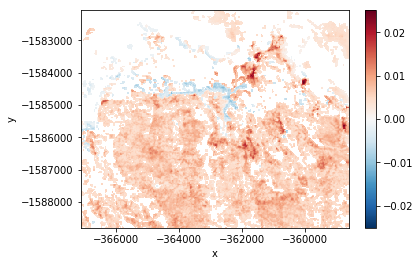

In [71]:
# Plot the grid

slope_xr.plot()
plt.show()